In [1]:
!pip install pycocotools


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
%load_ext autoreload
%autoreload 2

from pycocotools.coco import COCO
from bia_explorer import api
import matplotlib.pyplot as plt

In [3]:
study = api.BIAStudy.get_by_accession('S-BIAD463')
study

BIAStudy(attributes={}, annotations_applied=False, annotations=[StudyAnnotation(author_email='migration@ebi.ac.uk', key='annotation_type', value='geometrical annotations, weak annotations, bounding boxes, class labels', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='annotation_method', value='software', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='study_size_human_readable', value='22.1GiB', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='n_files_including_zip_contents', value='1346', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='models_uri', value='https://github.com/BIIFSweden/MariaUlvmar2020-1', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='annotation_summary', value='Automated detection and classification of high endothelial venules (HEVs) using deep learning', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='filetype_breakdown', value="{'.json': {'n': 61, 'size_in_bytes': 70641289, 'size': '67.4MiB'}, '.png': {'n': 1276, 'size_in_bytes': 3541187453, 'size': '3.3GiB'}, '.tiff': {'n': 9, 'size_in_bytes': 20138773685, 'size': '18.8GiB'}}", state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='example_annotation_uri', value='https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD463-annotation-example.png', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='filetype_breakdown_html', value='<ul><li>.json: 61 (67.4MiB)</li><li>.png: 1276 (3.3GiB)</li><li>.tiff: 9 (18.8GiB)</li></ul>', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='n_files_in_study', value='1346', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='models_description', value='HEV-finder: a deep learning tool', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='n_files_excluding_zip_contents', value='1346', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='study_size_in_bytes', value='23750602427', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='one_summary', value='Fluorescence images and geometrical annotations and classification of high endothelial venules (HEVs) in tumor-draining lymph nodes', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='study_size', value='22.1GiB', state=<AnnotationState.ACTIVE: 'active'>), StudyAnnotation(author_email='migration@ebi.ac.uk', key='example_image_uri', value='https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD463-example.png', state=<AnnotationState.ACTIVE: 'active'>)], context='https://raw.githubusercontent.com/BioImage-Archive/bia-integrator/main/api/src/models/jsonld/1.0/StudyContext.jsonld', uuid='00000000-0000-0000-0006-09b5e36ee327', version=4, model=ModelMetadata(type_name='BIAStudy', version=1), title='Automated detection of vascular remodeling in tumor-draining lymph nodes by the deep learning tool HEV-finder', description='Vascular remodeling is common in human cancer and has potential as future biomarkers for prediction of disease progression and tumor immunity status. It can also affect metastatic sites, including the tumor-draining lymph nodes (TDLNs). Dilation of the high endothelial venules (HEVs) within TDLNs has been observed in several types of cancer. We recently demonstrated that it is a pre-metastatic effect that can be linked to tumor invasiveness in breast cancer. Manual visual assessment of changes in vascular morphology is a tedious and difficult task, limiting high throughput analysis

In [4]:
coco_filerefs = None
for fileref in study.get_file_references():
    if fileref.uri.endswith("COCO_annotations.json"):
        coco_fileref = fileref
coco_fileref

FileReference(attributes={'Description': 'Annotations in the COCO format (see https://cocodataset.org/#format-data)', 'source image': 'my_submission/Training_coco/COCO_annotations.json', 'alias': 'AN1'}, annotations_applied=False, annotations=[], context='https://raw.githubusercontent.com/BioImage-Archive/bia-integrator/main/api/src/models/jsonld/1.0/FileReferenceContext.jsonld', uuid='d7538ca7-ed9a-4d89-93a0-60b4411a44ca', version=0, model=ModelMetadata(type_name='FileReference', version=1), study_uuid='00000000-0000-0000-0006-09b5e36ee327', name='my_submission/Training_coco/COCO_annotations.json', uri='https://ftp.ebi.ac.uk/biostudies/fire/S-BIAD/463/S-BIAD463/Files/my_submission/Training_coco/COCO_annotations.json', type='fire_object', size_in_bytes=70555536)

In [5]:
import requests
import json
import tempfile

response = requests.get(coco_fileref.uri)
annFile = response.json()

tempdir = tempfile.TemporaryDirectory()
with open(tempdir.name + '/COCO_annotations.json', 'a') as tf:
    json.dump(annFile, tf)

coco = COCO(tempdir.name + '/COCO_annotations.json')
tempdir.cleanup()

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!


In [6]:
categories = coco.loadCats(coco.getCatIds())
nms = [category['name'] for category in categories]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([category['supercategory'] for category in categories])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
not dilated vessel Intermediately dilated vessel highly dilated vessel CCL21+

COCO supercategories: 
tissue object


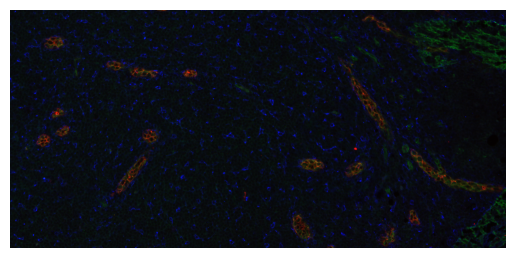

In [10]:
from PIL import Image
from io import BytesIO

# These values are study-specific,
#  and used to link images with annotations
PATIENT_ID = "Patient_033"
IMAGE_ID = "9"

impath = f'my_submission/Training_coco/IDC with metastasis/{PATIENT_ID}/{IMAGE_ID}.png'

image = [
    img
    for img in study.get_images()
    if str(img.original_relpath) == impath
][0]
im_data = image.representations[0].to_bytesio()
im_data = Image.open(im_data)

plt.axis('off')
plt.imshow(im_data)
plt.show()

In [11]:
annotations_file_reference = [
    fileref
    for fileref in study.get_file_references()
    if fileref.uri.endswith(f"{PATIENT_ID}/annotations.json")
][0]

idann = requests.get(annotations_file_reference.uri).json()

idann_dict = [
    item
    for item in idann
    if item['file_name'] == f"{IMAGE_ID}.png"
][0]
idann_dict

{'file_name': '9.png',
 'height': 929,
 'width': 1934,
 'mpp': 0.5,
 'key': 9,
 'global_x': 24964,
 'global_y': 22282,
 'id': 8777198959544207564}

IDC with metastasis/Patient_335/9.png


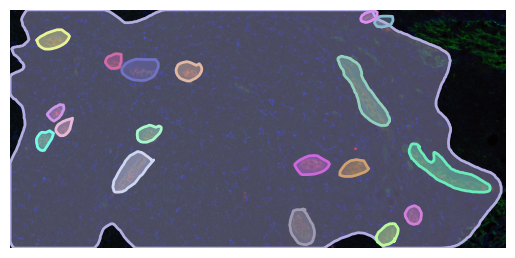

In [12]:
plt.imshow(im_data, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

annIds = coco.getAnnIds(imgIds=idann_dict['id'], iscrowd=None)
img_info = coco.loadImgs([idann_dict['id']])[0]
print(img_info["file_name"])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

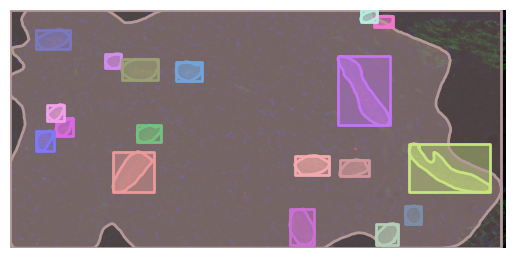

In [13]:
plt.imshow(im_data, cmap='gray', vmin=0, vmax=255); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)

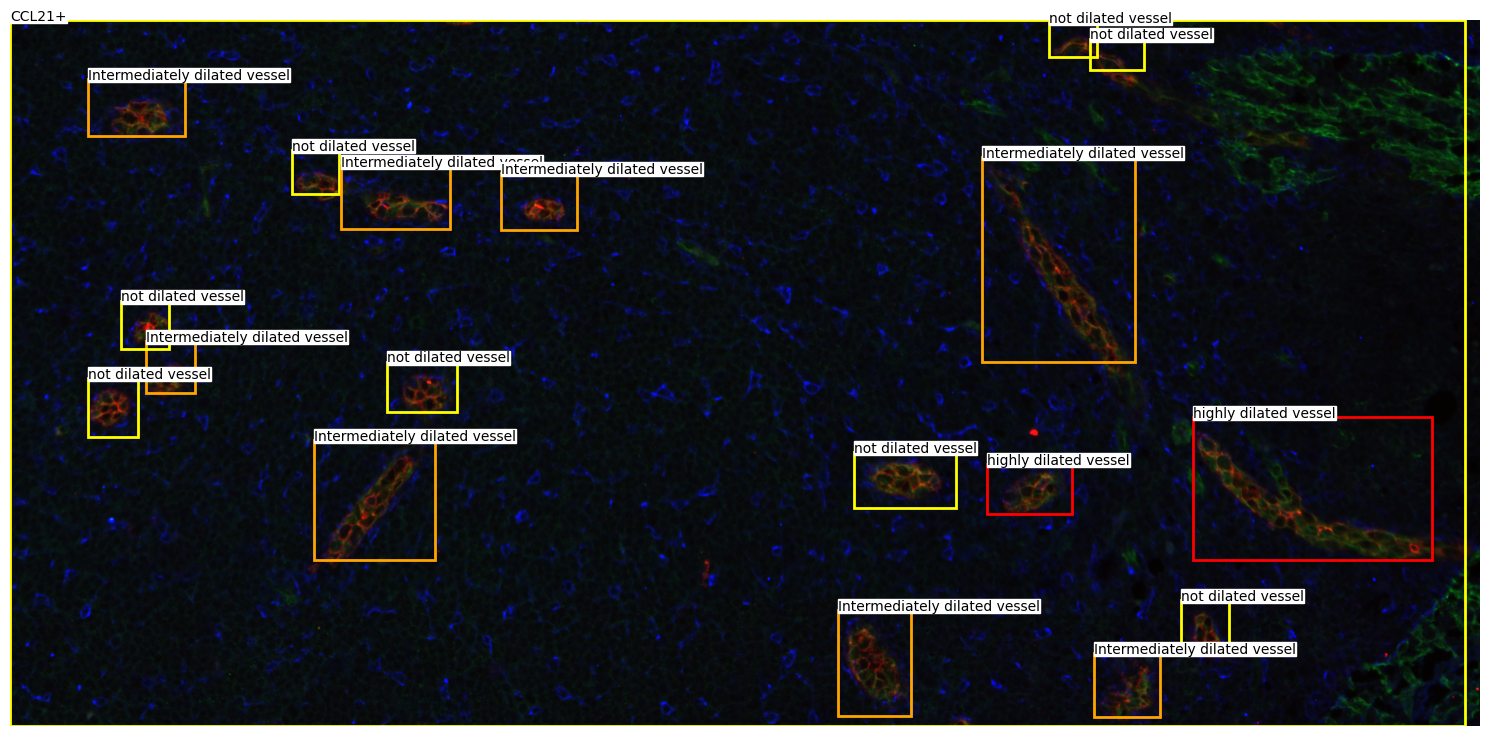

In [14]:
color_list = ["red", "yellow", "orange"]*10 # define a list of colors for drawing bounding boxes

fig, ax = plt.subplots(figsize=(15,10))

for ann in anns:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.loadCats(class_id)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')

        t_box = ax.text(x, y, class_name,  color='black', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=1, edgecolor='white'))
        ax.add_patch(rect)

ax.axis('off')
ax.imshow(im_data)
ax.set_xlabel('Longitude')


#plt.savefig('2_with_bb.png',pad_inches=0)
plt.tight_layout()
plt.show()